In [2]:
# Load data
#Load packages
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
from sklearn import linear_model
import torch
import seaborn as sns



# Data sources:
# https://data.mendeley.com/datasets/b5r4yztghx/2

# project (Rico)
# https://www.sciencedirect.com/science/article/abs/pii/S1877584518301175
# https://mc-stan.org/users/documentation/case-studies/icar_stan.html


# Artikel
# https://www1.nyc.gov/assets/doh/downloads/pdf/epi/databrief86.pdf

### perfomrnace metrics
Following metrics will be used to evaluate the performance of the models and how good they are at predicting the number of accidents amongst the youth populations.
* Accuracy..
* 

### Data
* Standardised?


#### Feature selection
we have many features, the model can very well be dirven by bias as many features has a high correlation..???

### Models

* baseline model
 >The baseline is based on the assumption that there is a linear relation between the events. The baseline is implemented using a linear regression on the data and will serve as a benchmark when evaluating the performance of the other models.

* Bayesian hierachial model
> From the maps and distributions from the exploratory analysis it seemed as some locations are more prone to accidents. Using an hierachical model it is investigeated if we can naturally cluster data into some groups and thereby be able to predict more accurately. Bayesian Hierachical models are able to produce robust models with clustered data. As the data seemed to cluster dependent on county, this is investigated. 

**copied** https://towardsdatascience.com/introduction-to-hierarchical-modeling-a5c7b2ebb1ca

 this method, parameters are nested within one another at different levels of groups. Roughly, it gives us the weighted average of the unpooled and pooled model estimates. Hierarchical modeling is one of the most powerful, yet simple, techniques in Bayesian inference and possibly in statistical modeling.


* Models with a non linear assumption
    > Extension of the hierachical model to include non linearity



* ???




### Function to performance metrics (?)

### Functions
* split function
* data standardisation function
* 

Cosinder moving to another file location (?)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model

In [4]:
 # Get input, output and groups by counties.
 def split_data(df, attributes,impute = False):
    X = df[df.columns[~df.columns.isin(attributes)]] 
    
    # Handling missing data - impute data based on the median.
    if impute:
        X = X.fillna(X.median()).values
    
    # Target variable
    y = df["ped_injury_5to18"].values
    
    # factorizes counties from strings to numerical valuers
    cat_fact = df['County'].factorize()
    cat = cat_fact[0] # numerical values for counties
    cat_string = cat_fact[1] # string values for counties

    # index
    ind = df.values[:,1].astype("int")
    
    # split data into train and test using permutation
    train_perc = 0.66 # percentage of training data
    split_point = int(train_perc*len(y))
    perm = np.random.permutation(len(y))
    ix_train = perm[:split_point]
    ix_test = perm[split_point:]
    X_train = X[ix_train,:]
    X_test = X[ix_test,:]
    cat_train = cat[ix_train]
    cat_test = cat[ix_test]
    y_train = y[ix_train]
    y_test = y[ix_test]
    ind_train = ind[ix_train]
    ind_test = ind[ix_test]
    

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, cat_train.shape, cat_test.shape)
    
    return (X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string



def standardization(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

### Load and prepare data for modelling

In [5]:
# Load data
df_all = pd.read_csv("data/data_merged.csv")  

In [6]:
# df_all.info()

In [7]:
    # Attriutes that are stirng - either make the dummy variables or remove them
string_att = list(df_all.columns[df_all.dtypes == object])
    # df_all.loc[:, df_all.dtypes == object]
nominal = ['census_tract']
removed_attributes = nominal+string_att

# split target variables and variables into training and test data
(X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string = split_data(df_all, removed_attributes,True)

(1382, 39) (713, 39) (1382,) (713,) (1382,) (713,)


In [8]:
# Standardise data
#X_train_mean = X_train.mean(axis=0)
#X_train_std = X_train.std(axis=0)
#X_train = (X_train - X_train_mean) / X_train_std
#X_test = (X_test - X_train_mean) / X_train_std


In [9]:
X_train_std = standardization(X_train)
X_test_std = standardization(X_test)

**OBS: TILFØJ! - Burde man kigge på balancen af splittet i forhold til counties evt?**
* imbalanced datasæt

# Baseline model

An Ordinary least square regression is performed

In [10]:
# make linear regression model
l_reg = linear_model.LinearRegression(fit_intercept=False)
l_reg.fit(X_train_std, y_train)


LinearRegression(fit_intercept=False)

In [11]:
# Make predictions for test set
ypred_lreg = l_reg.predict(X_test_std)
print("first 5 predictions:", ypred_lreg[:5])
print("first 5 true values:", y_test[:5])

# Evaluate prediction accuracy
print("Baseline MSE:", sum((ypred_lreg - y_test)**2)/len(ypred_lreg))

# Vi får ikke det samme some de andre - måske noget gal

first 5 predictions: [-8.36821245e+09 -1.64881286e+10 -5.43414995e+09 -1.19021570e+10
  3.33734043e+08]
first 5 true values: [14  5  4  3  5]
Baseline MSE: 3.250768535489239e+20


In [12]:
# look at the error
mae = np.mean(np.abs(y_test-ypred_lreg))
print("MAE:", mae)

MAE: 13213208198.778938


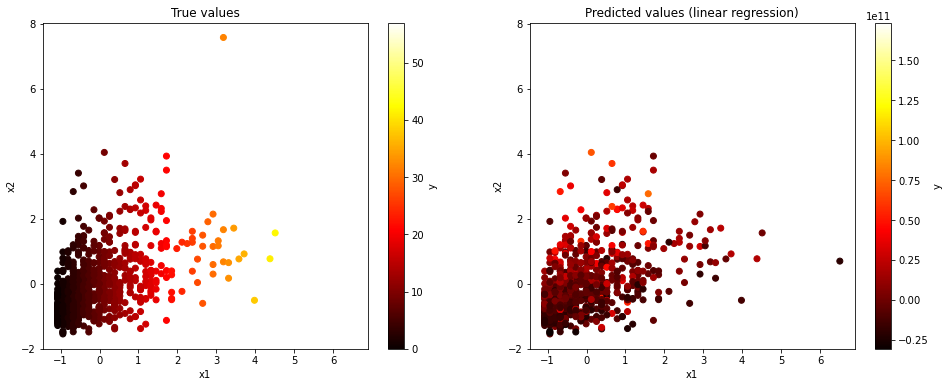

In [13]:
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1,2)
sc = ax[0].scatter(X_test_std[:,0], X_test_std[:,1], c=y_test, cmap=plt.cm.hot)
ax[0].set_title('True values')
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
plt.colorbar(sc, ax=ax[0], label="y")
sc = ax[1].scatter(X_test_std[:,0], X_test_std[:,1], c=ypred_lreg, cmap=plt.cm.hot)
ax[1].set_title('Predicted values (linear regression)')
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
plt.colorbar(sc, ax=ax[1], label="y")
plt.show()

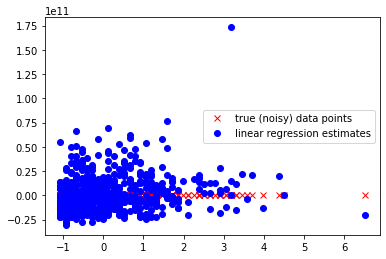

In [14]:
plt.plot(X_test_std[:,0], y_test, "rx")
plt.plot(X_test_std[:,0], ypred_lreg, 'bo')
plt.legend(["true (noisy) data points", "linear regression estimates"])
plt.show()

Det ser lidt mærkeligt ud...


# Hierachical model

... classification ...

Data is investigated further using a hierachical model, to examine if data are distirbuted dependent on some underlying patterns that can help us in our prediction model. 

The hierachical model is based upon the assumption that some areas are more prone to accidents that other accidents. This assumption is made based on the exploratory analysis where it was evident that XXX and XX were two areas that had more accidents compared to the others. 

In the hierarchical model data are grouped into L distinct levels. The model is buildt such that on one extreme each level is assigned its own set of parameters that is estimated seperately from the other levels resulting in no pooling, and the other extreme where all data share a common globar hyper prior that ties the parameters of each level together resulring in complete pooling. In this wat the hierarchical model is an intermediate solution where the degree of pooling is determined by the data and a prior on the amount of pooling \ref{https://mc-stan.org/docs/2_23/stan-users-guide/hierarchical-logistic-regression.html}



the prediction variable is the categorial variable cat, as we are prediction counties 







In [15]:
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [33]:
def hierarchical_model(X ,ind, n_cat, n_ind, obs=None, y=False):
    """_Hierarchical logistic regression_
    
    

    Args:
        X (matrix): data observations (prediciton vairables)
        n_cat (int): number of categories (different counties)
        obs (_type_, optional): _description_. Defaults to None.
        y (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    
    # Number of observations and features
    N, input_dim = X.shape
    
    # Draw parameters 
    
    # Prior for the bias mean
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(torch.zeros(n_cat), 
                                                       10.*torch.ones(n_cat)).to_event()) 
    # Prior for the bias standard deviation
    alpha_sigma  = pyro.sample("alpha_sigma",  
                               dist.HalfCauchy(10.*torch.ones(n_cat)).to_event()) 
    
    
    # Priors for the regression coefficents
    beta  = pyro.sample("beta", 
                        dist.Normal(
                            torch.zeros(input_dim, n_cat), 
                                            10.*torch.ones(input_dim, n_cat)).to_event())
        
        
    with pyro.plate("level", n_ind):
        # Draw linear coefficient parameters for each level (no pooling)
        alpha = pyro.sample(
            "alpha",
                dist.Normal(alpha_mu, alpha_sigma).to_event(1)
        )
        
    
    with pyro.plate("observations", N):
        # Compute mean for psi-distribution with linear model
        
        # regression model
        logits = alpha[ind] + X.matmul(beta)

        # Sample prediction using logits (then we do not need softmax)
        y = pyro.sample("y", 
                        dist.Categorical(logits=logits), 
                        obs=obs) 
        
    
    return y

Next step is to prepare data for pyro in order to use the model to predict

In [34]:
# Prepare data for Pyro model
# convert ty torch tensors
X_train = torch.tensor(X_train).float()
cat_train = torch.tensor(cat_train).long()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
n_ind = ind.max()
ind_train = torch.tensor(ind_train).long() # these are indices, therefore they need to be (long) integers
#cat_test = torch.tensor(y_test).float()

# number of coutnies
n_cat = int(len(df_all['County'].unique()))
#n_cat_amx = ind.max()

#ind_train = torch.tensor(ind_train).long() # these are indices, therefore they need to be (long) integers

C:\Users\KAPH\AppData\Local\Temp/ipykernel_16764/1659179851.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
C:\Users\KAPH\AppData\Local\Temp/ipykernel_16764/1659179851.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cat_train = torch.tensor(cat_train).long()
C:\Users\KAPH\AppData\Local\Temp/ipykernel_16764/1659179851.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()
C:\Users\KAPH\AppData\Local\Temp/ipykernel_16764/1659179851.py:6: UserWarning: To cop

In [37]:
%%time

# Define guide function
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 12000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, ind_train-1, n_cat, n_ind, cat_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 778168564.2
[500] ELBO: 139733240.5
[1000] ELBO: 37153741.2
[1500] ELBO: 13655449.4
[2000] ELBO: 5446050.4
[2500] ELBO: 2186095.0
[3000] ELBO: 1062761.0
[3500] ELBO: 563767.2
[4000] ELBO: 340454.2
[4500] ELBO: 254121.1
[5000] ELBO: 212242.5
[5500] ELBO: 171366.8
[6000] ELBO: 175379.1
[6500] ELBO: 138805.6
[7000] ELBO: 136773.0
[7500] ELBO: 101970.4
[8000] ELBO: 124011.4
[8500] ELBO: 115695.0
[9000] ELBO: 149773.1
[9500] ELBO: 92414.3
[10000] ELBO: 130201.0
[10500] ELBO: 73500.5
[11000] ELBO: 87726.0
[11500] ELBO: 75334.2
Wall time: 4min 6s


Extract the posterior samples and investigate if any county is more likely to have accidents than others

In [43]:
# Extract the posterior samples
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha", "alpha_mu", "alpha_sigma"))
samples = predictive(X_train, ind_train-1, n_cat, n_ind, cat_train-1)



In [44]:
# plot the posterior distirbution of the parameters
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()

C:\Users\KAPH\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\KAPH\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\KAPH\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

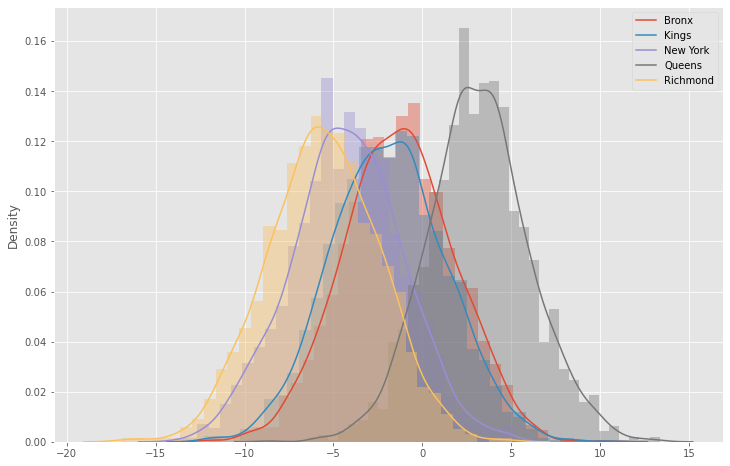

In [63]:
for c in range(n_cat):
    sns.distplot(alpha_mu_samples[:,0,c])
plt.legend([cat_string[c] for c in range(n_cat)])
fig.savefig('output/hierarchical_model_logit.pdf', format="pdf")
plt.show()

C:\Users\KAPH\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\KAPH\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\KAPH\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

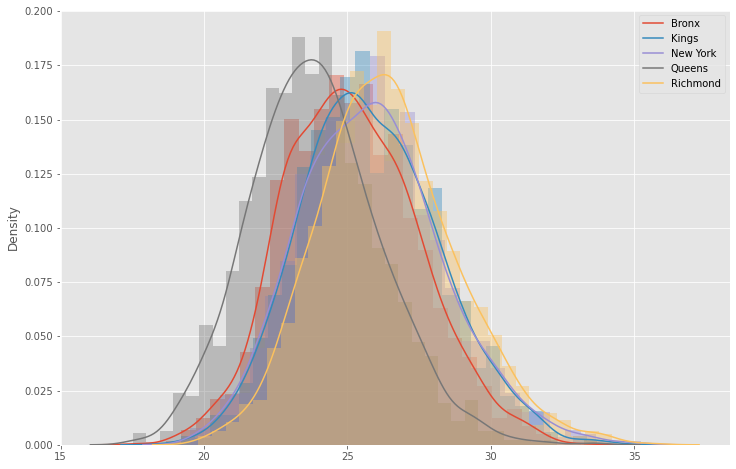

In [64]:
for c in range(n_cat):
    sns.distplot(alpha_sigma_samples[:,0,c])
plt.legend([cat_string[c] for c in range(n_cat)])
plt.show()

Te model has not seperated the parameters that much?

**make predictions**
We can now use the inferred poseriors to make predictions. irst the expetec values for the paraemters, it is possible to make prediction for the test set.

In [71]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"][:,0].mean(axis=0).detach().numpy()

# make predictions for test set
y_hat = alpha_hat[cat_test,:] + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) 
print("predictions:", y_hat)
print("true values:", cat_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == cat_test) / len(cat_test))

print("MSE   (mean posterior):", sum((y_hat - y_test)**2)/len(y_hat))

predictions: [0 3 3 0 3 2 0 3 0 1 2 0 1 0 1 2 2 0 0 0 0 1 1 1 3 1 3 3 3 3 1 1 0 1 1 2 1
 1 3 0 2 1 1 1 3 1 3 2 1 0 3 1 0 3 3 3 3 1 1 1 1 1 1 4 1 3 3 4 3 2 1 1 0 3
 1 2 1 1 2 1 1 1 3 1 3 2 2 1 3 3 3 0 0 1 3 0 3 3 1 2 1 0 2 3 0 2 3 1 0 0 0
 1 2 0 1 1 3 1 3 3 0 4 0 0 0 2 3 3 1 3 1 2 0 0 3 2 4 3 1 2 3 1 0 2 0 3 0 0
 1 3 1 2 3 2 3 3 0 1 3 1 2 0 0 1 1 0 1 1 0 2 3 0 2 0 1 0 1 2 2 1 1 3 3 3 4
 0 3 1 0 1 3 1 1 4 1 3 1 0 0 3 1 3 0 2 0 3 1 1 3 3 2 0 3 0 2 3 1 4 1 1 1 1
 3 1 3 1 0 3 1 1 4 1 1 2 1 0 0 1 1 1 1 1 1 3 1 0 1 3 1 1 1 3 1 1 1 3 1 1 2
 3 3 2 3 0 3 0 3 0 1 3 2 0 1 3 1 0 0 3 3 3 2 4 1 1 3 1 0 3 3 3 1 3 2 1 3 0
 1 3 3 0 3 3 1 0 0 3 3 3 1 3 4 0 3 2 0 3 2 0 1 2 2 3 2 3 0 2 2 1 1 2 1 0 1
 2 0 1 1 0 0 3 1 0 0 0 1 1 3 0 0 1 4 3 1 1 1 0 2 1 1 1 2 0 3 0 1 3 3 3 3 1
 3 1 0 1 2 4 0 3 3 2 3 3 4 2 3 1 3 2 1 3 2 3 3 1 1 4 1 3 1 1 0 3 1 1 3 0 3
 1 4 1 2 1 0 1 1 3 4 3 3 3 4 3 1 0 1 3 0 0 1 0 1 2 3 1 3 2 0 1 3 1 3 2 1 1
 0 0 3 1 3 1 1 0 4 4 1 3 3 3 0 4 0 3 1 1 3 1 4 3 3 1 2 3 1 1 1 3 3 3 0 2 3
 0 1 0 3 3 3

Vi skal prediktere antallet af accidents? Lige nu prediktere vi bydel??
Kig på drengenes - giver ikke helt mening??

## Regression model - Bayesian neural network





In [72]:
# Create architecture
class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.tanh = torch.nn.Tanh()
        
    def forward(self, X):
        # Forward pass
        X = self.tanh(self.in_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        
        return X

Adding priors in the neural network on its weights

In [73]:
def nnet_model(X, y=None):
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1], n_hidden=4, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    # The generative process
    with pyro.plate("observations"):
        prediction_mean = sampled_model(X).squeeze(-1) # Feed-forward the design matrix X through the neural network
        y = pyro.sample("obs", dist.Normal(prediction_mean, 0.1), obs=y)
        
    return y

In [74]:
# Define guide function
guide = AutoDiagonalNormal(nnet_model)

# Reset parameter values
pyro.clear_param_store()

In [75]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

C:\Users\KAPH\Anaconda3\lib\site-packages\pyro\primitives.py:491: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


[0] ELBO: 8708963.0
[500] ELBO: 3800482.8
[1000] ELBO: 3799679.0
[1500] ELBO: 3794883.6
[2000] ELBO: 3799590.6
[2500] ELBO: 3792752.7
[3000] ELBO: 3800199.6
[3500] ELBO: 3801405.2
[4000] ELBO: 3800710.6
[4500] ELBO: 3800765.5
[5000] ELBO: 3800714.3
[5500] ELBO: 3800733.1
[6000] ELBO: 3800717.6
[6500] ELBO: 3800811.1
[7000] ELBO: 3800736.9
[7500] ELBO: 3800699.4
[8000] ELBO: 3851894.8
[8500] ELBO: 3800882.0
[9000] ELBO: 3800910.0
[9500] ELBO: 3801635.6


In [76]:
# Prepare test data for Pyro
X_test = torch.tensor(X_test).float()

C:\Users\KAPH\AppData\Local\Temp/ipykernel_16764/327537019.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()


In [77]:
from pyro.infer import Predictive

# Make predictions for test set
predictive = Predictive(nnet_model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test)

In [78]:
y_pred = samples["obs"].mean(axis=0).detach().numpy()
mae = np.mean(np.abs(y_test - y_pred))
print("MAE:", mae)

MAE: 5.668460375797865


In [79]:
def nnet_interpretable_model(X, y=None):
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1]-1, n_hidden=4, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    # Linear model priors
    beta_lin = pyro.sample("beta", dist.Normal(0, 1))
    
    # The generative process
    with pyro.plate("observations"):
        linear_out = X[:,0]*beta_lin
        nn_out = sampled_model(X[:,1:]).squeeze(-1) # Feed-forward the design matrix X through the neural network
        y = pyro.sample("obs", dist.Normal(linear_out+nn_out, 0.1), obs=y)
        
    return y

In [81]:
# Define guide function
guide = AutoDiagonalNormal(nnet_interpretable_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_interpretable_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

C:\Users\KAPH\Anaconda3\lib\site-packages\pyro\primitives.py:491: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


[0] ELBO: 11496547.5
[500] ELBO: -154.3
[1000] ELBO: -1723.6
[1500] ELBO: -1737.2
[2000] ELBO: -1838.8
[2500] ELBO: -1853.8
[3000] ELBO: -1822.4
[3500] ELBO: -1785.0
[4000] ELBO: -1830.0
[4500] ELBO: -1864.4
[5000] ELBO: -1729.3
[5500] ELBO: -1867.2
[6000] ELBO: -1814.3
[6500] ELBO: -1479.7
[7000] ELBO: -1852.7
[7500] ELBO: -1775.5
[8000] ELBO: -1536.9
[8500] ELBO: -1798.6
[9000] ELBO: -1865.1
[9500] ELBO: -1790.2


In [83]:
from pyro.infer import Predictive

# Get posterior samples for beta
predictive = Predictive(nnet_interpretable_model, guide=guide, num_samples=1000,
                        return_sites=("beta",))
samples = predictive(X_train, y_train)

C:\Users\KAPH\Anaconda3\lib\site-packages\pyro\primitives.py:491: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


In [84]:
print("Estimated beta:", samples["beta"].mean(axis=0).detach().numpy()[0])

Estimated beta: 0.99969786


In [86]:
# Make predictions for test set
predictive = Predictive(nnet_interpretable_model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test)

y_pred = samples["obs"].mean(axis=0).detach().numpy()
mae = np.mean(np.abs(y_test - y_pred))
print("MAE:", mae)

MAE: 0.01096453180756723


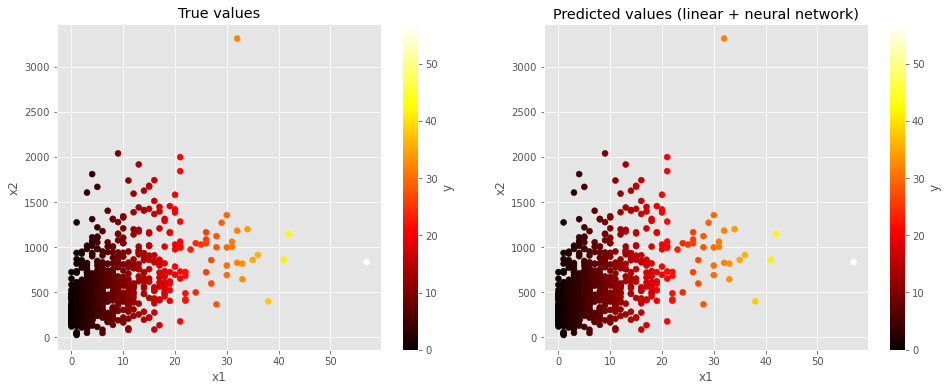

In [87]:
# Two subplots, the axes array is 1-d
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1,2)
sc = ax[0].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.hot)
ax[0].set_title('True values')
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
plt.colorbar(sc, ax=ax[0], label="y")
sc = ax[1].scatter(X_test[:,0], X_test[:,1], c=y_pred, cmap=plt.cm.hot)
ax[1].set_title('Predicted values (linear + neural network)')
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
plt.colorbar(sc, ax=ax[1], label="y")
plt.show()

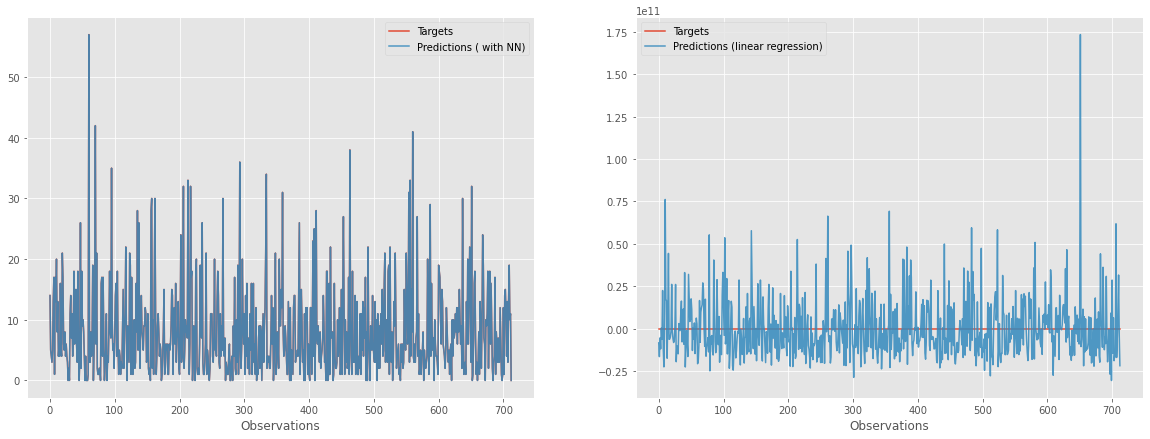

In [92]:
# Visualize predictions from the combined model and linear regression
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_pred, label="Predictions ( with NN)", alpha=0.85)
ax[0].legend()
ax[0].set_xlabel("Observations")

ax[1].plot(y_test, label="Targets")
ax[1].plot(ypred_lreg, label="Predictions (linear regression)", alpha=0.85)
ax[1].legend()
ax[1].set_xlabel("Observations")
plt.show()

# Hierachical model with a non linear assumption

# Extra model?